# Description

See description in `00-no_covars/20-gtex_v8-no_covars-gls_sub_corrs.ipynb`.

This notebook is the same but for results using some covariates.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "covars"
    / "_corrs_5mb"
    / "gls-gtex_v8_mashr-sub_corr"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results):
    lv_code = None
    lvs = results["lv"].unique()
    if lvs.shape[0] == 1:
        lv_code = lvs[0]

    traits = results["phenotype"].unique()

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = qqplot(results[PVALUE_COLUMN])
        if lvs.shape[0] == 1:
            ax.set_title(f"{lv_code} - {traits.shape[0]} traits")
        else:
            ax.set_title(f"{lvs.shape[0]} LVs - {traits.shape[0]} traits")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.395322,0.125894,3.140123,0.001696,0.000848,random.pheno988
1,LV175,0.331859,0.124790,2.659353,0.007849,0.003924,random.pheno988
2,LV116,0.337790,0.130191,2.594575,0.009492,0.004746,random.pheno988
3,LV585,0.323672,0.124886,2.591744,0.009571,0.004785,random.pheno988
4,LV816,0.322661,0.124720,2.587093,0.009701,0.004850,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.05578622087132725

# QQ-plot

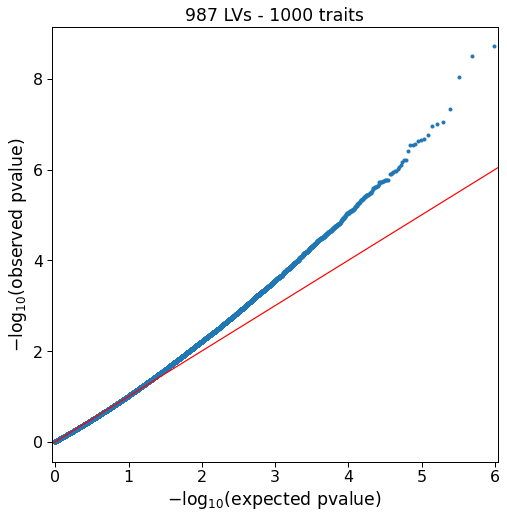

In [18]:
qqplot_unif(dfs)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.023,0.061
1,LV10,0.013,0.035,0.069
2,LV100,0.013,0.052,0.084
3,LV101,0.011,0.040,0.090
4,LV102,0.013,0.058,0.083


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.014775,0.055786,0.102652
std,0.005123,0.012673,0.018564
min,0.001000,0.016000,0.051000
25%,0.011000,0.047000,0.090000
50%,0.014000,0.056000,0.102000
75%,0.018000,0.063000,0.115000
max,0.035000,0.111000,0.176000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(89, 4)

,lv,1,5,10
561,LV604,0.015,0.049,0.099
384,LV445,0.011,0.049,0.081
843,LV859,0.016,0.049,0.087
450,LV504,0.011,0.049,0.093
838,LV854,0.016,0.049,0.087
821,LV839,0.018,0.049,0.091
819,LV837,0.018,0.049,0.091
507,LV556,0.013,0.049,0.097
544,LV59,0.016,0.049,0.088
774,LV797,0.014,0.049,0.090


,lv,1,5,10
62,LV155,0.009,0.051,0.089
90,LV180,0.018,0.051,0.112
128,LV214,0.010,0.051,0.105
191,LV271,0.013,0.051,0.107
212,LV290,0.018,0.051,0.099
300,LV37,0.012,0.051,0.097
324,LV391,0.013,0.051,0.097
722,LV75,0.014,0.051,0.114
356,LV42,0.009,0.051,0.104
414,LV472,0.015,0.051,0.095


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(330, 4)

,lv,1,5,10
310,LV379,0.024,0.083,0.125
369,LV431,0.022,0.084,0.137
253,LV327,0.026,0.085,0.132
672,LV704,0.018,0.085,0.149
341,LV406,0.019,0.086,0.133
752,LV777,0.021,0.086,0.156
151,LV235,0.029,0.087,0.138
946,LV951,0.025,0.088,0.157
975,LV978,0.022,0.088,0.148
892,LV902,0.028,0.088,0.138


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
941,LV45,-0.234276,0.141205,-1.659120,0.097140,0.951430,random.pheno988
1244,LV45,0.078323,0.141696,0.552755,0.580450,0.290225,random.pheno589
2167,LV45,0.120872,0.141316,0.855331,0.392400,0.196200,random.pheno385
3546,LV45,-0.036517,0.141363,-0.258317,0.796170,0.601915,random.pheno5
4425,LV45,-0.009052,0.141440,-0.064001,0.948971,0.525514,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.012

In [32]:
show_prop(results, 0.05)

0.069

In [33]:
show_prop(results, 0.10)

0.131

In [34]:
show_prop(results, 0.15)

0.184

In [35]:
show_prop(results, 0.20)

0.23

### QQplot

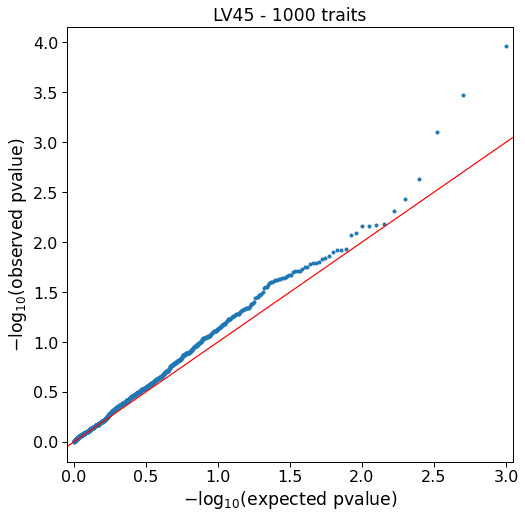

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
517,LV234,-0.027060,0.143899,-0.188050,0.850843,0.574578,random.pheno988
1872,LV234,-0.180468,0.144297,-1.250666,0.211102,0.894449,random.pheno589
2911,LV234,-0.219704,0.143922,-1.526549,0.126922,0.936539,random.pheno385
3636,LV234,-0.069257,0.144032,-0.480849,0.630640,0.684680,random.pheno5
4381,LV234,0.012264,0.144100,0.085110,0.932176,0.466088,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.014

In [43]:
show_prop(results, 0.05)

0.053

In [44]:
show_prop(results, 0.10)

0.09

In [45]:
show_prop(results, 0.15)

0.119

In [46]:
show_prop(results, 0.20)

0.16

### QQplot

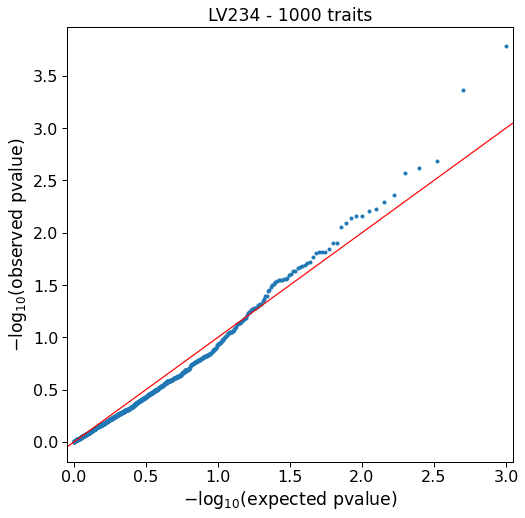

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
281,LV847,0.059926,0.141410,0.423774,0.671745,0.335872,random.pheno988
1531,LV847,-0.039309,0.141909,-0.276997,0.781791,0.609105,random.pheno589
2782,LV847,-0.127960,0.141503,-0.904293,0.365874,0.817063,random.pheno385
3419,LV847,0.011380,0.141580,0.080376,0.935941,0.467970,random.pheno5
4586,LV847,-0.061061,0.141656,-0.431054,0.666443,0.666778,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.021

In [54]:
show_prop(results, 0.05)

0.066

In [55]:
show_prop(results, 0.10)

0.125

In [56]:
show_prop(results, 0.15)

0.19

In [57]:
show_prop(results, 0.20)

0.236

### QQplot

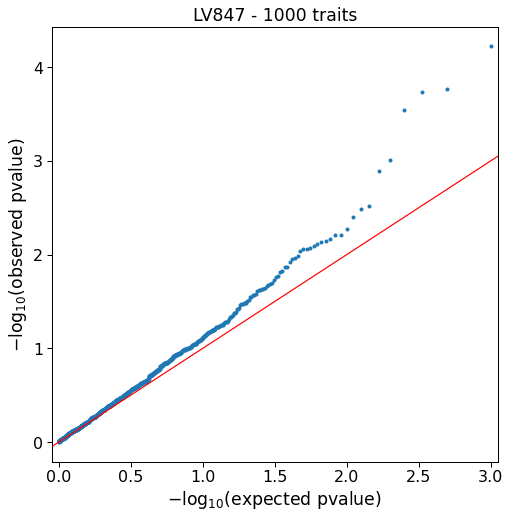

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
964,LV110,-0.266359,0.138432,-1.924118,0.054384,0.972808,random.pheno988
1696,LV110,-0.097721,0.138838,-0.703849,0.481552,0.759224,random.pheno589
2794,LV110,-0.129909,0.138524,-0.937806,0.348379,0.825810,random.pheno385
3580,LV110,-0.044249,0.138608,-0.319236,0.749558,0.625221,random.pheno5
4934,LV110,-0.347366,0.138588,-2.506467,0.012219,0.993891,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.017

In [65]:
show_prop(results, 0.05)

0.051

In [66]:
show_prop(results, 0.10)

0.105

In [67]:
show_prop(results, 0.15)

0.155

In [68]:
show_prop(results, 0.20)

0.211

### QQplot

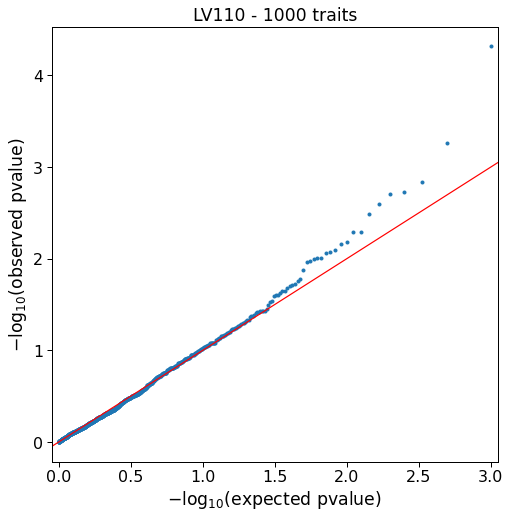

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
212,LV769,0.089871,0.124871,0.719708,0.471731,0.235865,random.pheno988
1296,LV769,0.049709,0.125103,0.397349,0.691124,0.345562,random.pheno589
2518,LV769,-0.017541,0.124962,-0.140369,0.888372,0.555814,random.pheno385
3871,LV769,-0.162302,0.124950,-1.298940,0.194011,0.902994,random.pheno5
4916,LV769,-0.235284,0.125053,-1.881465,0.059954,0.970023,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.022

In [76]:
show_prop(results, 0.05)

0.072

In [77]:
show_prop(results, 0.10)

0.132

In [78]:
show_prop(results, 0.15)

0.18

In [79]:
show_prop(results, 0.20)

0.242

### QQplot

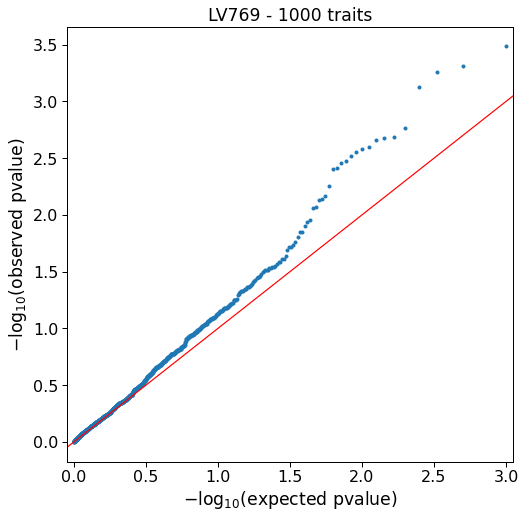

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
96,LV800,0.185413,0.149104,1.243509,0.213726,0.106863,random.pheno988
1408,LV800,0.014917,0.149358,0.099875,0.920447,0.460223,random.pheno589
2801,LV800,-0.142208,0.149151,-0.953449,0.340398,0.829801,random.pheno385
3695,LV800,-0.094337,0.149155,-0.632475,0.527099,0.736451,random.pheno5
4373,LV800,0.016381,0.149319,0.109704,0.912648,0.456324,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.023

In [87]:
show_prop(results, 0.05)

0.07

In [88]:
show_prop(results, 0.10)

0.115

In [89]:
show_prop(results, 0.15)

0.158

In [90]:
show_prop(results, 0.20)

0.207

### QQplot

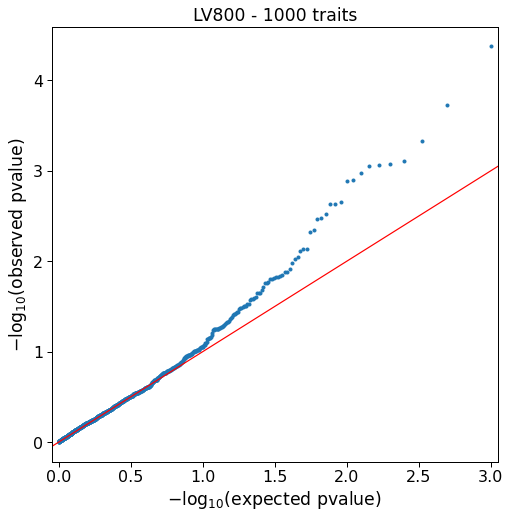

In [91]:
qqplot_unif(results)

## LV806

In [92]:
lv_code = "LV806"

In [93]:
results = dfs[dfs["lv"] == lv_code]

In [94]:
results.shape

(1000, 7)

In [95]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
742,LV806,-0.090394,0.127429,-0.709368,0.478122,0.760939,random.pheno988
1331,LV806,0.037927,0.127681,0.297042,0.766444,0.383222,random.pheno589
2097,LV806,0.144441,0.127563,1.132316,0.257544,0.128772,random.pheno385
3704,LV806,-0.083392,0.127525,-0.653927,0.513182,0.743409,random.pheno5
4237,LV806,0.060166,0.127648,0.471347,0.637409,0.318705,random.pheno74


In [96]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [97]:
show_prop(results, 0.01)

0.009

In [98]:
show_prop(results, 0.05)

0.038

In [99]:
show_prop(results, 0.10)

0.08

In [100]:
show_prop(results, 0.15)

0.108

In [101]:
show_prop(results, 0.20)

0.155

### QQplot

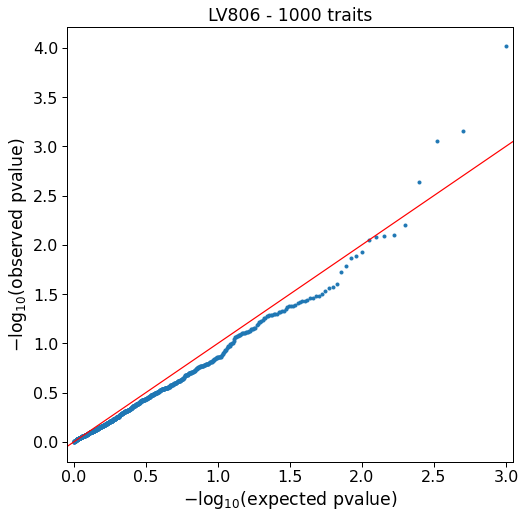

In [102]:
qqplot_unif(results)

# LVs with expected mean type I error

In [103]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
561,LV604,0.015,0.049,0.099
384,LV445,0.011,0.049,0.081
843,LV859,0.016,0.049,0.087
450,LV504,0.011,0.049,0.093
838,LV854,0.016,0.049,0.087
821,LV839,0.018,0.049,0.091
819,LV837,0.018,0.049,0.091
507,LV556,0.013,0.049,0.097
544,LV59,0.016,0.049,0.088
774,LV797,0.014,0.049,0.090


In [104]:
lv_results_expected = {}

## LV412

In [105]:
lv_code = "LV412"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
617,LV412,-0.048630,0.125064,-0.388839,0.697408,0.651296,random.pheno988
1717,LV412,-0.094823,0.125283,-0.756865,0.449158,0.775421,random.pheno589
2007,LV412,0.239780,0.125112,1.916523,0.055343,0.027671,random.pheno385
3146,LV412,0.108686,0.125143,0.868497,0.385155,0.192577,random.pheno5
4018,LV412,0.179472,0.125256,1.432836,0.151953,0.075977,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.015

In [111]:
show_prop(results, 0.05)

0.045

In [112]:
show_prop(results, 0.10)

0.095

In [113]:
show_prop(results, 0.15)

0.132

In [114]:
show_prop(results, 0.20)

0.191

### QQplot

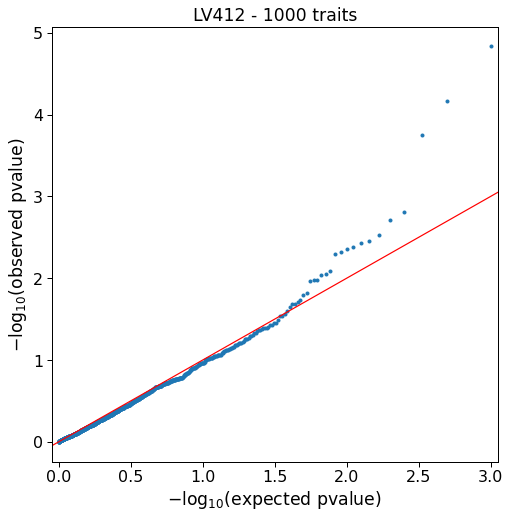

In [115]:
qqplot_unif(results)

## LV57

In [116]:
lv_code = "LV57"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
718,LV57,-0.081908,0.126778,-0.646073,0.518255,0.740873,random.pheno988
1287,LV57,0.053125,0.126882,0.418695,0.675453,0.337727,random.pheno589
2122,LV57,0.126222,0.126858,0.994987,0.319780,0.159890,random.pheno385
3514,LV57,-0.023738,0.126872,-0.187099,0.851589,0.574205,random.pheno5
4293,LV57,0.038535,0.126986,0.303459,0.761550,0.380775,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.013

In [122]:
show_prop(results, 0.05)

0.044

In [123]:
show_prop(results, 0.10)

0.087

In [124]:
show_prop(results, 0.15)

0.133

In [125]:
show_prop(results, 0.20)

0.168

### QQplot

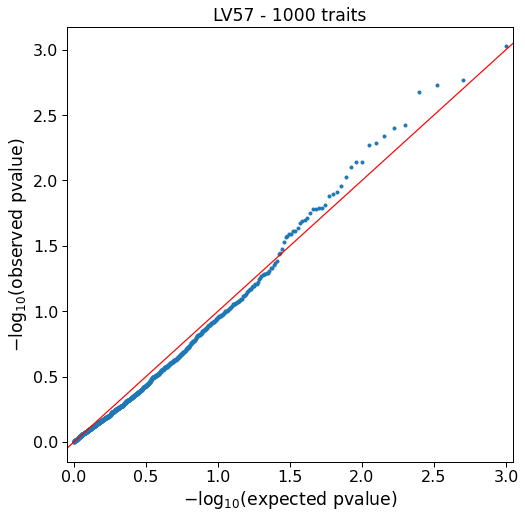

In [126]:
qqplot_unif(results)

## LV647

In [127]:
lv_code = "LV647"

In [128]:
results = dfs[dfs["lv"] == lv_code]

In [129]:
results.shape

(1000, 7)

In [130]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
717,LV647,-0.080101,0.125313,-0.639207,0.522711,0.738645,random.pheno988
1495,LV647,-0.022361,0.125547,-0.178107,0.858644,0.570678,random.pheno589
2593,LV647,-0.046699,0.125401,-0.372398,0.709609,0.645196,random.pheno385
3082,LV647,0.142710,0.125392,1.138110,0.255117,0.127558,random.pheno5
4629,LV647,-0.067351,0.125527,-0.536546,0.591600,0.704200,random.pheno74


In [131]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [132]:
show_prop(results, 0.01)

0.013

In [133]:
show_prop(results, 0.05)

0.057

In [134]:
show_prop(results, 0.10)

0.105

In [135]:
show_prop(results, 0.15)

0.152

In [136]:
show_prop(results, 0.20)

0.201

### QQplot

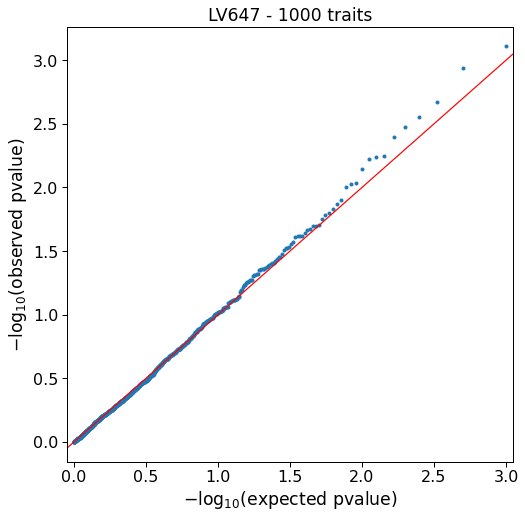

In [137]:
qqplot_unif(results)